In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pdf-documents/beginners-guide-to-saving-2024.pdf
/kaggle/input/pdf-documents/tips-to-manage-your-money.pdf
/kaggle/input/pdf-documents/1_55_ways_to_save.pdf
/kaggle/input/pdf-documents/How-to-Manage-your-Finances.pdf
/kaggle/input/pdf-documents/40MoneyManagementTips.pdf


# personal Finance management advisor 


 **A Retrieval-Augmented Generation (RAG) pipeline enhances AI-powered personal finance tools by combining real-time data retrieval with LLM-generated insights. This allows users to ask natural language questions (e.g., "How can I reduce my monthly expenses?") and receive accurate, context-aware answers based on their financial data.**

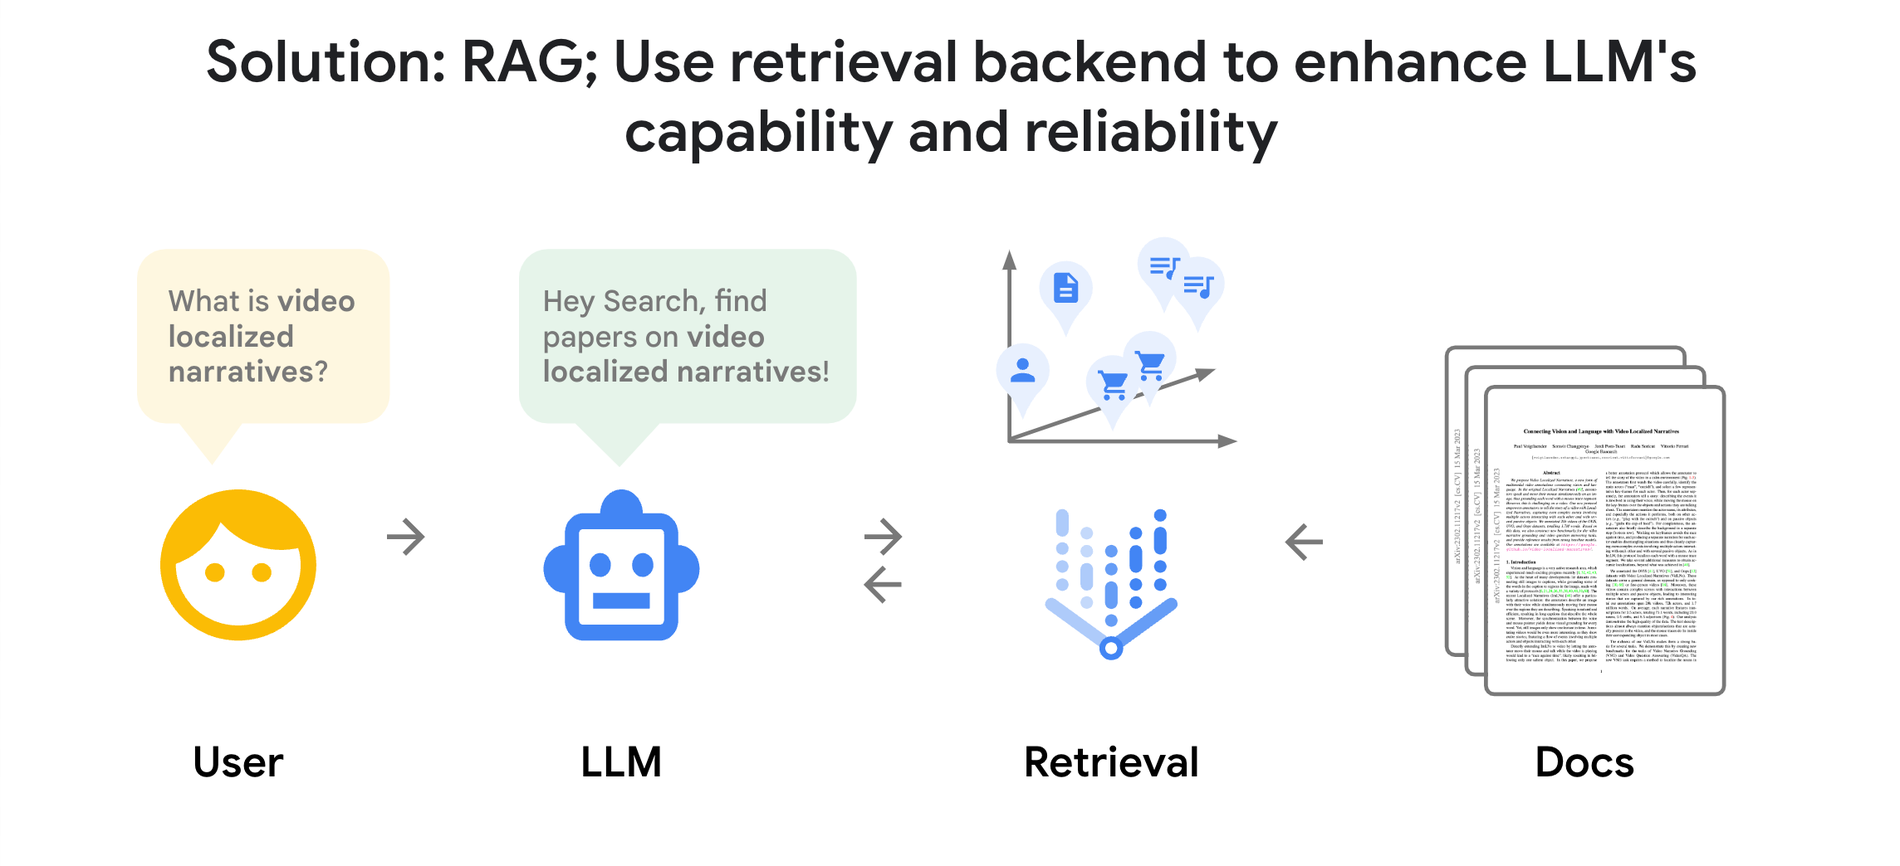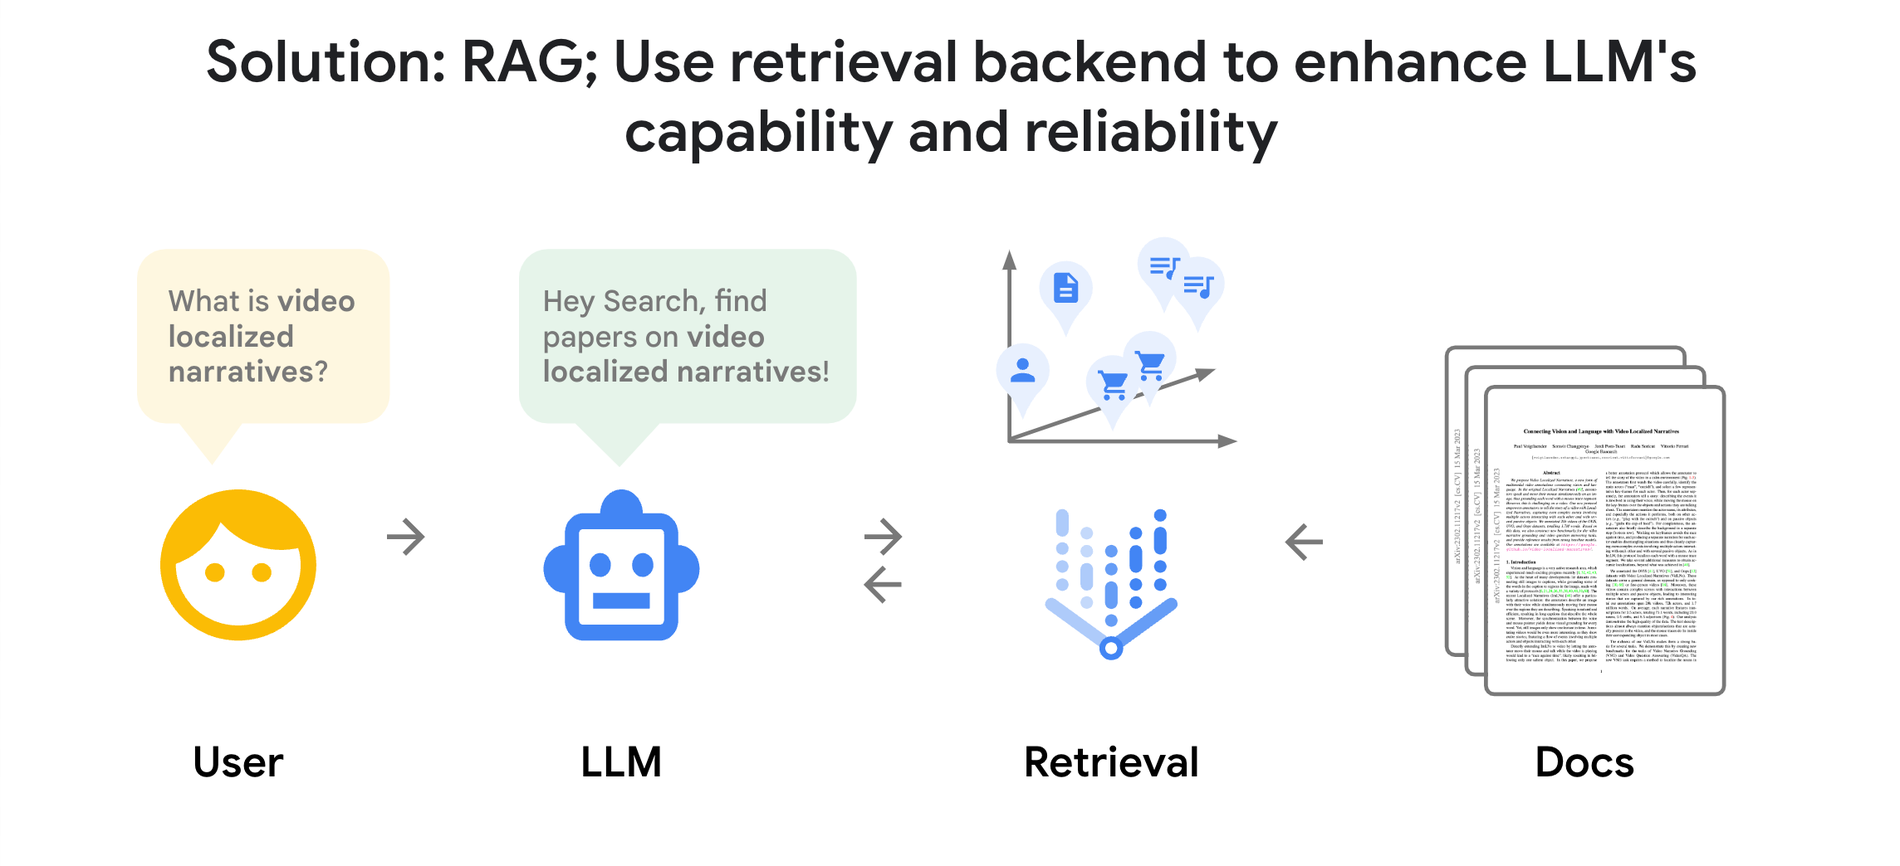
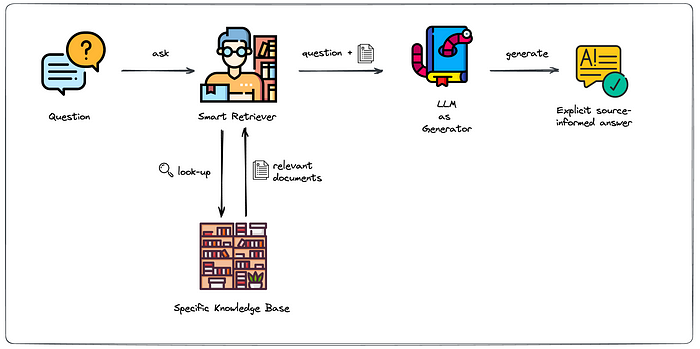
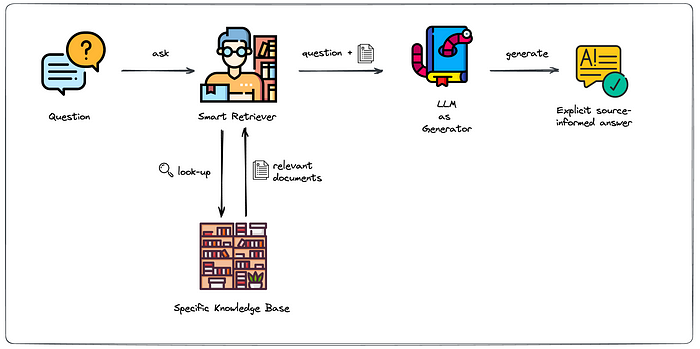
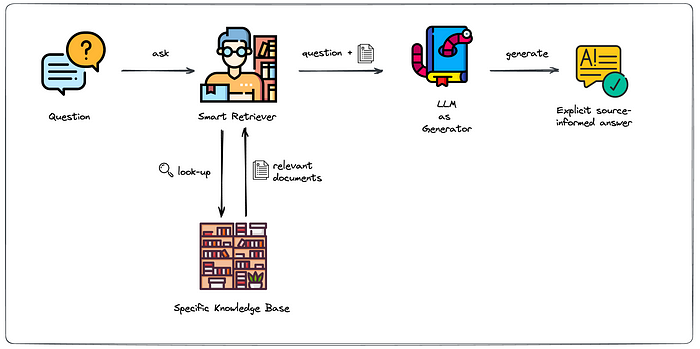
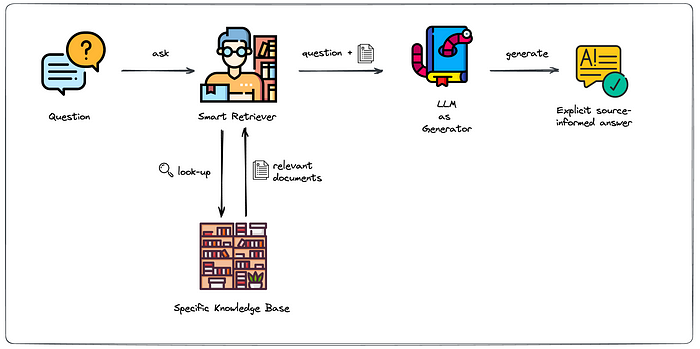
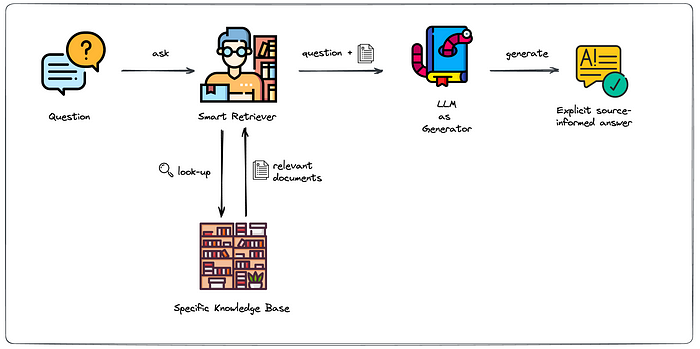
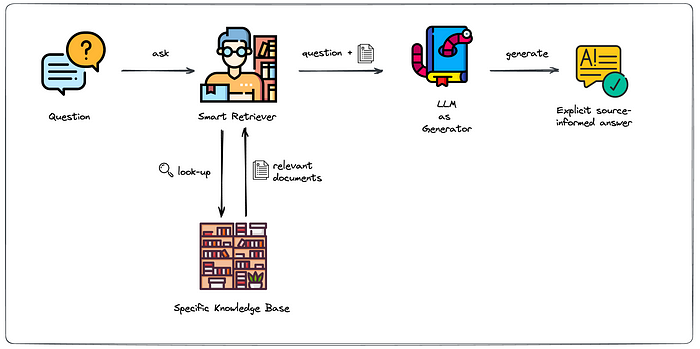

## Import Libraries

In [49]:
#pip install faiss-cpu
#!pip install --upgrade langchain-core langchain
#!pip install langchain-google-genai
#!pip install -U langchain langchain-core langchain-community langchain-google-genai
#!pip install google-generativeai
#!pip install PyPDF2
#!pip install chromadb
#!pip install langchain-google-genai

In [39]:
from google import genai
from google.genai import types
genai.__version__
from kaggle_secrets import UserSecretsClient
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate
import google.generativeai as genai
import numpy as np
from langchain.docstore.document import Document
from langchain.embeddings.base import Embeddings
from langchain.chat_models import ChatGooglePalm


## Set up your API key

In [40]:
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

## Reading pdf documents 

In [53]:
from PyPDF2 import PdfReader

# Specify the exact path to one PDF file
pdf_files = ['/kaggle/input/pdf-documents/1_55_ways_to_save.pdf',
           '/kaggle/input/pdf-documents/40MoneyManagementTips.pdf',
           '/kaggle/input/pdf-documents/How-to-Manage-your-Finances.pdf',
           '/kaggle/input/pdf-documents/beginners-guide-to-saving-2024.pdf',
           '/kaggle/input/pdf-documents/tips-to-manage-your-money.pdf']
# Load and split PDF
documents = []
for pdf in pdf_files:
    loader = PyPDFLoader(pdf)
    documents.extend(loader.load())

text_splitter = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=90)
chunks = text_splitter.split_documents(documents)
texts = [chunk.page_content.strip() for chunk in chunks if chunk.page_content.strip()]
# Convert texts to LangChain Documents
documents = [Document(page_content=text) for text in texts]


**After extracting text from the PDF files, the data must be divided into smaller, manageable segments called chunks. This preprocessing step is essential for converting the text into numerical representations known as embeddings in a vector space.**

## Create an Embedding using Gemeni API

In [52]:
#Initialize Gemini Embeddings (modern approach)
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.vectorstores import Chroma
from langchain.schema import Document
from langchain.chains import RetrievalQA
embedding_function = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",
    google_api_key=GOOGLE_API_KEY
)

**"models/embedding-001" Gemini’s default embedding model.**

Generated the Gemini embeddings for your text chunks. Now let’s connect that directly to Chromadb using your current variables (texts, embeddings). Here’s the next step to build and store your Chromadb vector index using the embeddings you just generated.

## Create Chromadb

In [54]:
# Create Chroma vectorstore
#  CREATE COLLECTION with the custom embedding function 
from chromadb.config import Settings

chroma_client = Client(Settings())

collection = chroma_client.create_collection(
    name="financial_docs"
)
vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=embedding_function,
    collection_name="financial_docs",
    persist_directory="./chroma_db"
)

## Create a memory to enable answering follow-up questions.

In [43]:
# --- Setup Memory for Conversational AI ---
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

## Create Retrevial

In [55]:
# Create retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

## Define LLM  chat model

In [56]:
# Initialize the Gemini (or other LLM) Chat Model 
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY,model="gemini-pro", temperature=0.7)


**The temperature variable specifies the model's creativity level and that's why we get different answers even if we ask the same question**

## Create a zero-shot prompt templete 

In [57]:
# 1. Adjust your template to match expected variables
template = """
You are a personal finance assistant. Based on the user's question and the retrieved documents, provide useful and actionable advice.

Context: {context}

Chat History: {chat_history}

Question: {question}

Your response should provide clear, step-by-step advice tailored to the user's needs.
"""

# 2. Create prompt with correct variables
prompt = PromptTemplate(
    input_variables=["context", "chat_history", "question"],
    template=template
)

## Create a RAG Pipeline

In [65]:
from langchain.chains import ConversationalRetrievalChain
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import PromptTemplate
#  Create the base QA chain first
qa_chain = load_qa_chain(
    llm=llm,
    chain_type="stuff",
    prompt=prompt,
    verbose=True
)

#  Now create the conversational chain
conversational_chain = ConversationalRetrievalChain(
    retriever=vectorstore.as_retriever(search_kwargs={"k": 4}),
    memory=memory,
    question_generator=llm,
    combine_docs_chain=qa_chain,
    verbose=True
)

/tmp/ipykernel_137/404755998.py:5: LangChainDeprecationWarning: This class is deprecated. See the following migration guides for replacements based on `chain_type`:
stuff: https://python.langchain.com/docs/versions/migrating_chains/stuff_docs_chain
map_reduce: https://python.langchain.com/docs/versions/migrating_chains/map_reduce_chain
refine: https://python.langchain.com/docs/versions/migrating_chains/refine_chain
map_rerank: https://python.langchain.com/docs/versions/migrating_chains/map_rerank_docs_chain

See also guides on retrieval and question-answering here: https://python.langchain.com/docs/how_to/#qa-with-rag
  qa_chain = load_qa_chain(


ValidationError: 1 validation error for StuffDocumentsChain
  Value error, document_variable_name context was not found in llm_chain input_variables: ['chat_history', 'question', 'retrieved_documents'] [type=value_error, input_value={'llm_chain': LLMChain(ve...None, 'callbacks': None}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error